### Loading

In [1]:
from util import open_experiment_table
df, df_params = open_experiment_table(filepath='big_exp_final.sqlite')
df_params

/Users/michele/computer_science/code/OriginOfSymmetry/.venv/lib/python3.10/site-packages/pandas/io/sql.py:1600: SAWarning: TypeDecorator JSONEncodedMultineatParameters() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this type object's state is safe to use in a cache key, or False to disable this warning. (Background on this warning at: https://sqlalche.me/e/20/cprf)
  return self.con.execute(sql, *args)
/Users/michele/computer_science/code/OriginOfSymmetry/.venv/lib/python3.10/site-packages/pandas/io/sql.py:1600: SAWarning: TypeDecorator JSONEncodedDict() will not produce a cache key because the ``cache_ok`` attribute is not set to True.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this att

,id,body_multineat_parameters,brain_multineat_parameters,evolution_parameters
0,1,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...
1,2,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...
2,3,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...
3,4,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...
4,5,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...
5,6,<multineat._multineat.Parameters object at 0x1...,<multineat._multineat.Parameters object at 0x1...,EvolutionParameters(database_file=./big_exp_fi...


### Selecting experiments based on parameters

In [6]:
# dict  in the form
# {
#     index: True if targets are 3 
# }

targets = {}

for i, row in df_params.iterrows():
    evol_params = row["evolution_parameters"]
    target_list = evol_params.target_list
    targets[row["id"]] = len(target_list) == 3

targets

{1: False, 2: False, 3: True, 4: False, 5: False, 6: True}

In [5]:
# dict  in the form
# {
#     index: True if steering is enabled
# }

steering = {}

for i, row in df_params.iterrows():
    evol_params = row["evolution_parameters"]
    steering[row['id']] = evol_params.steer

steering


{1: True, 2: True, 3: True, 4: False, 5: False, 6: False}

In [7]:
# select paramters with both 3 targets and steering enabled

selected = []

for i in targets:

    if targets[i] and steering[i]:
        selected.append(i)

selected

[3]

In [8]:
# df with only selected parameters
df_selected = df[df["parameters_id"].isin(selected)]

In [9]:
df_selected.tail()

,experiment_id,parameters_id,generation_index,fitness,symmetry,xy_positions,population_index
399995,20,3,199,-5.907461,0.0,"[ActorState(position=Vector3([0. , 0. ...",95
399996,20,3,199,-5.182462,0.0,"[ActorState(position=Vector3([0. , 0. ...",96
399997,20,3,199,-5.276556,0.0,"[ActorState(position=Vector3([0. , 0. ...",97
399998,20,3,199,-5.354085,0.0,"[ActorState(position=Vector3([0. , 0. ...",98
399999,20,3,199,-4.415940,0.0,"[ActorState(position=Vector3([0. , 0. ...",99


### Plot paths

In [11]:
from pyrr import Quaternion, Matrix33, Vector3
import numpy as np

def rotate_vector_with_pyrr(quaternion, vector=Vector3([1.0, 0.0, 0.0])):
    # Create a Quaternion object from the given quaternion
    q = Quaternion(quaternion)
    # Convert the quaternion into a rotation matrix
    rotation_matrix = Matrix33.from_quaternion(q)
    # Apply the rotation matrix to the vector
    rotated_vector = rotation_matrix * vector
    # Return the rotated vector (you can ignore the z-component for 2D)
    return rotated_vector.xy


In [25]:
del get_body_states_from_str

In [33]:
from revolve2.modular_robot._body_state import BodyState
from revolve2.simulation.running._results import ActorState


get_body_states_from_str = lambda x: eval(x)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
#from balance_compute import get_body_states_from_str

def plot_core_path_single_generation(body_states, exp, gen,steer, condition, path_type="vector", n_robots=-1, step_time=7, scale=3, seed=0, save_img=False, best_fitness_index=None, best_sym_index=None, best_bal_index=None):
    assert step_time > 0
    assert n_robots > 0 or n_robots == -1
    assert path_type in ["vector", "point", "both"]
    assert step_time > 0

    # select random robots if needed
    np.random.seed(seed)
    if n_robots == -1:
        n_robots = len(body_states)
    n_total_robots = len(body_states)
    body_states = np.random.choice(body_states, n_robots, replace=False)
    
    best_path_x, best_path_y = None, None
    best_sym_x, best_sym_y = None, None
    best_bal_x, best_bal_y = None, None

    for i, single_robot_body_state_str in enumerate(body_states):
        # translate bodystates to readable objects
        single_robot_states = get_body_states_from_str(single_robot_body_state_str)

        # convert to BodyState objects if needed
        if isinstance(single_robot_states[0], ActorState):

            single_robot_states = [BodyState(core_orientation=actor_state.orientation, core_position=actor_state.position) for actor_state in single_robot_states]
        
        # collect positions
        core_positions = [body_state.core_position for body_state in single_robot_states]
        final_x = [core_positions[-1].x]
        final_y = [core_positions[-1].y]
        x = [core_position.x for core_position in core_positions][::step_time]+final_x
        y = [core_position.y for core_position in core_positions][::step_time]+final_y
        
        # collect xy vector orientations
        core_xy_orientations = [rotate_vector_with_pyrr(body_state.core_orientation) for body_state in single_robot_states]
        final_vector = [core_xy_orientations[-1]]
        vectors = np.array(core_xy_orientations[::step_time]+final_vector)

        if best_fitness_index is not None and i == best_fitness_index:
            best_fitness_x, best_fitness_y = x, y
            
        if best_sym_index is not None and i == best_sym_index:
            best_sym_x, best_sym_y = x, y

        if best_bal_index is not None and i == best_bal_index:
            best_bal_x, best_bal_y = x, y
            
        if path_type == "point" or path_type=="both":
            plt.plot(x[0], y[0], "go")      # starting point
            # plt.plot(x[-1], y[-1], "ro")    # end point
            plt.plot(x, y, color="grey")   # rest of path
            

        
        if path_type == "vector" or path_type=="both":
            U, V = vectors[:, 0], vectors[:, 1]
            plt.quiver(x, y, U, V, 
                       angles='xy', scale_units='xy', scale=scale, linewidths=0.5, width=0.005, color="grey")
            plt.quiver(final_x, final_y, final_vector[0][0], final_vector[0][1], 
                       angles='xy', scale_units='xy', scale=scale, color="red", linewidths=0.5, width=0.005)

    # plot best robot
    plt.plot(best_fitness_x, best_fitness_y, color="green", label="Best fitness")
    plt.plot(best_sym_x, best_sym_y, color="pink", linestyle="--", label="Best symmetry")
    #plt.plot(best_bal_x, best_bal_y, color="red", linestyle=":", label="Best balance")
    
    # useful information to console
    print(f"Number of robots shown:    {n_robots}/{n_total_robots}")
    print(f"Number of timesteps shown: {len(core_positions)//step_time}/{len(core_positions)}")
    
    # plot target at (5,5)
    plt.plot([5], 5, "rx")

    # plot target at (-5,5) with another color
    plt.plot([-5], 5, "bx")

    # plot target at (0,sqrt(50)) with another color
    plt.plot([0], np.sqrt(50), "gx")
    
    # boilerplate readability
    plt.grid(True)
    plt.legend()
    plt.ylim(-1,8)
    plt.xlim(-6,6)
    plt.xlabel("x")
    plt.ylabel("y")
    # get the steer and target list

    

    

    plt.title("Core path for experiment " + str(exp) + " generation " + str(gen)+ " con.:" + condition + " steering: " + str(steer))
    if save_img:
        plt.savefig(f"pilot/paths/core_path_exp_{exp}_gen_{gen}.png", bbox_inches="tight")

    plt.show()


In [50]:
df.head()

,experiment_id,parameters_id,generation_index,fitness,symmetry,xy_positions,population_index
0,1,1,0,-7.070885,0.666667,"[ActorState(position=Vector3([0. , 0. ...",0
1,1,1,0,-6.943401,0.250000,"[ActorState(position=Vector3([0. , 0. ...",1
2,1,1,0,-7.094302,0.500000,"[ActorState(position=Vector3([0. , 0. ...",2
3,1,1,0,-7.095749,0.400000,"[ActorState(position=Vector3([0. , 0. ...",3
4,1,1,0,-6.785198,0.222222,"[ActorState(position=Vector3([0. , 0. ...",4


In [48]:
[(0,1)] == [(0,0)]

False

Number of robots shown:    100/100
Number of timesteps shown: 3/31


TypeError: can only concatenate str (not "bool") to str

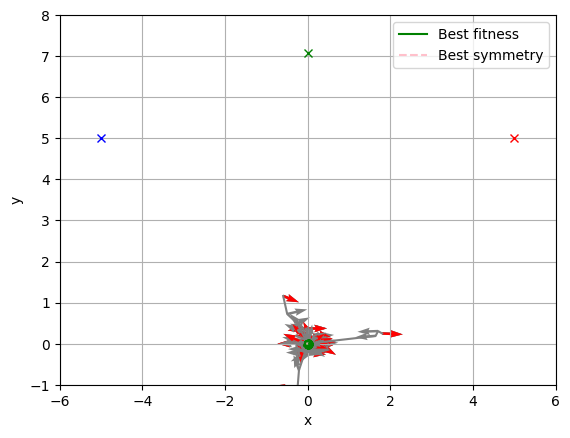

In [53]:
# sample 3 random experiments
import math
# get experiment ids
exp_ids = df_selected["experiment_id"].unique()

# select 3 random experiments
random_exp = np.random.choice(exp_ids, 3, replace=False)

# get 10 random experiments from the original df
random_exp = np.random.choice(df["experiment_id"].unique(), 10, replace=False)



for ex in df["experiment_id"].unique():
    for i, gen in enumerate(df[df["experiment_id"] == ex]["generation_index"].unique()):
        if i%50==0 or i==max(df[df["experiment_id"] == ex]["generation_index"].unique()):
            df_sub = df[(df["experiment_id"] == ex) & (df["generation_index"] == gen)]
            best_fitness_index = np.argmax(df_sub["fitness"])
            best_sym_index = np.argmax(df_sub["symmetry"])
            #best_bal_index = np.argmax(df_sub["balance"])
            body_states = df[(df["experiment_id"] == ex) & (df["generation_index"] == gen)]["xy_positions"]


            # get condition and steering
            #get params
            param_id = df_sub["parameters_id"].iloc[0]
            evol_params = df_params[df_params["id"]==param_id].loc[:, "evolution_parameters"]
            assert len(evol_params) == 1

            steer = evol_params.iloc[0].steer

            target_list = evol_params.iloc[0].target_list

            if target_list == [[0,math.sqrt(50)], [5,5],[-5,5]]:
                condition = "T3"
            elif target_list == [[5,5]]:
                    condition = "T1"
            elif target_list == [[0,math.sqrt(50)]]:
                    condition = "T2"
            else:
                print(f"Unknown target list{target_list}")
                break
            
            plot_core_path_single_generation(body_states, ex, gen, steer, condition, path_type="both", n_robots=-1, step_time=10, 
                                             scale=2, seed=None, best_fitness_index=best_fitness_index, best_sym_index=best_sym_index, 
                                             best_bal_index=None, save_img=False)
            # break

In [23]:
type(df.iloc[0]["xy_positions"])

str